In [110]:
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['figure.subplot.bottom'] = 0.15 



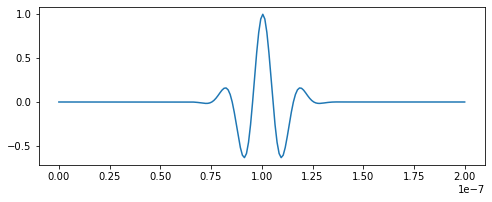

In [111]:
#%%
#practicing on a gaussian pulse, this is how you can use broadbean's primitives
g = bb.broadbean.PulseAtoms.gaussian(1, 10e-9, 0, 0, 1e9, 200)
s = bb.broadbean.PulseAtoms.sine(50e6, 1, 0, np.pi/2, 1e9, 100*2)
t = np.linspace(0, 200/1e9, 200)
plt.plot(t, g*s) #a guassian pulse at 50MHz!
#make the custom function #first t
def gaussian_pulse(freq, phase, ampl, sigma, mu, offset, SR, npts):
    g = bb.broadbean.PulseAtoms.gaussian(1, sigma, mu, offset, SR, npts)
    s = bb.broadbean.PulseAtoms.sine(freq, ampl, offset, phase, SR, npts)
    return g*s


Legend: Name, function, arguments, timesteps, durations
Segment 1: "waituntil", waituntil, (3e-07,), None
Segment 2: "mypulse", gaussian_pulse, (50000000.0, 4.71238898038469, 0.05, 5e-08, 0, 0), 2e-07
Segment 3: "mysine", PulseAtoms.sine, (50000000.0, 0.05, 0, 0), 2.01e-07
Segment 4: "waituntil2", waituntil, (8e-07,), None
----------


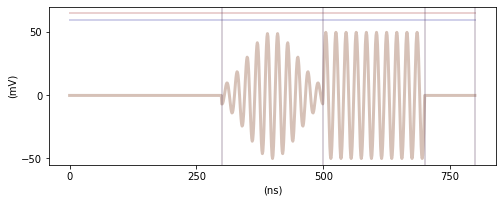

In [112]:

#%%
#now you can insert this into a blueprint 
#question: what if I want a custom function? -> probably make it according to PulseAtoms framework -> yep!
sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
bp1 = bb.BluePrint()
bp1.setSR(1e9)
bp1.insertSegment(1, 'waituntil', (300e-9,))
bp1.insertSegment(2, gaussian_pulse, (50e6,3*np.pi/2,50e-3,50e-9,0,0), name = 'mypulse', dur = 200e-9)
# bp1.insertSegment(1, sine, (20e6, 5e-3, 0, 0), name='mysine', dur=201e-9)
bp1.insertSegment(3, sine, (50e6, 50e-3, 0, 0), name='mysine', dur=201e-9)
bp1.insertSegment(4, 'waituntil', (800e-9,))
bp1.showPrint()
plotter(bp1)

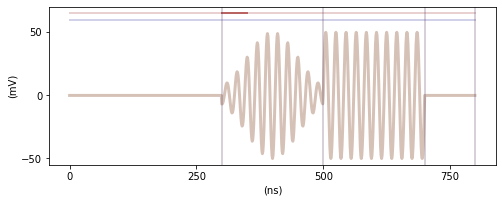

In [92]:
#add a marker towards the beginning to trigger the Alazar, for example
bp1.marker1 = [(300e-9, 50e-9)]
plotter(bp1)

Legend: Name, function, arguments, timesteps, durations
Segment 1: "mysine", PulseAtoms.sine, (100000000.0, 0.005, 0, 0), 2.01e-07
Segment 2: "mypulse", gaussian_pulse, (100000000.0, 4.71238898038469, 0.005, 5e-08, 0, 0), 2e-07
Segment 3: "waituntil", waituntil, (5e-07,), None
----------


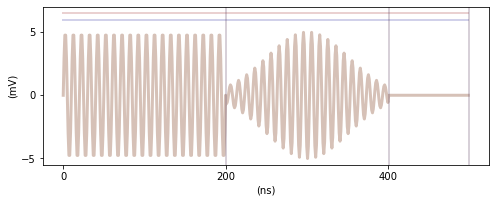

In [103]:
#make a similar one with the order switched up
bp2 = bb.BluePrint()
bp2.setSR(1e9)
#order matters! even if you specify position 3, you cant put it before 2
bp2.insertSegment(1, sine, (100e6, 5e-3, 0, 0), name='mysine', dur=201e-9)
bp2.insertSegment(2, gaussian_pulse, (100e6,3*np.pi/2,5e-3,50e-9,0,0), name = 'mypulse', dur = 200e-9)
bp2.insertSegment(3, 'waituntil', (500e-9,))
bp2.showPrint()
plotter(bp2)

Designated channels: [1, 2]
Total duration: 8e-07 s
Sample rate: 1000000000.0 (Sa/S)


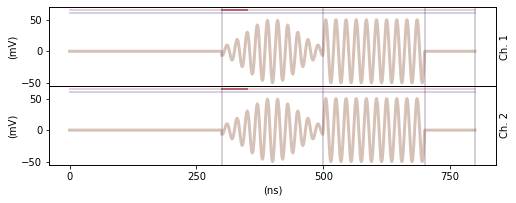

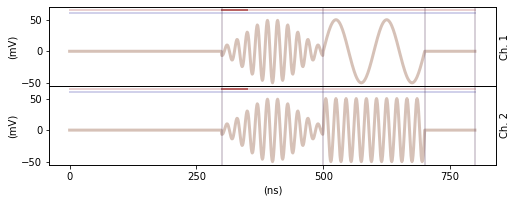

In [104]:
#now we need to throw these into an element! An element holds blueprints, and sorts them into channels. all blueprints
#in an element need to have the same number of points
elem1 = bb.Element()
elem1.addBluePrint(1,bp1)
elem1.addBluePrint(2,bp1)
plotter(elem1)

elem1.validateDurations()  # raises an ElementDurationError if something is wrong. If all is OK, does nothing.
# An element has several features
print('Designated channels: {}'.format(elem1.channels))
print('Total duration: {} s'.format(elem1.duration))
print('Sample rate: {} (Sa/S)'.format(elem1.SR))

#you can also change things in an element
elem1.changeArg(1, 'mysine', 'freq', 10e6 )
plotter(elem1)

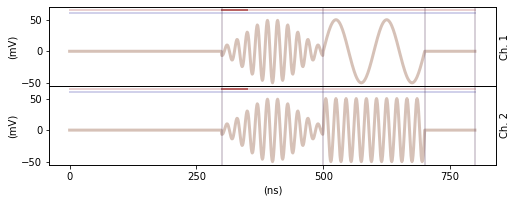

In [105]:
#now we can finally put these elements into sequences
seq1 = bb.Sequence()

seq1.addElement(1,elem1)
seq1.setSR(elem1.SR)

seq1.checkConsistency()
plotter(seq1)


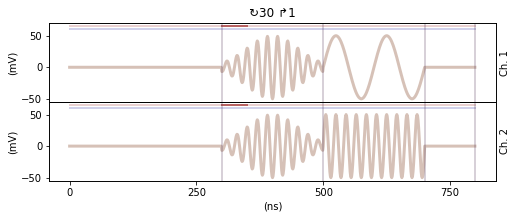

In [106]:
#now we have to prep it for the AWG
seq1.setChannelAmplitude(1, 100e-3)  # Call signature: channel, amplitude (peak-to-peak)
seq1.setChannelOffset(1, 0)
seq1.setChannelAmplitude(2, 100e-3) 
seq1.setChannelOffset(2, 0) 

#set the sequencing
# Here we repeat each element twice and then proceed to the next, wrapping over at the end
seq1.setSequencingTriggerWait(1, 0)
seq1.setSequencingNumberOfRepetitions(1, 30)
seq1.setSequencingEventJumpTarget(1, 0)
seq1.setSequencingGoto(1, 1)

#
plotter(seq1)
seq1.checkConsistency()
#package for AWG

package = seq1.outputForAWGFile()
chan1_awg_input = package[0]
chan2_awg_input = package[1]
package.channels
awg.make_send_and_load_awg_file(*package[:])

In [67]:
from hatdrivers.Hat_AWG5014C import Hat_AWG5014C
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg = Tektronix_AWG5014('AWG2', 'TCPIP0::169.254.116.102::inst0::INSTR', timeout=40)

KeyError: 'Another instrument has the name: AWG2'

In [47]:
awg.make_send_and_load_awg_file(*package[:])

In [17]:
awg.close()

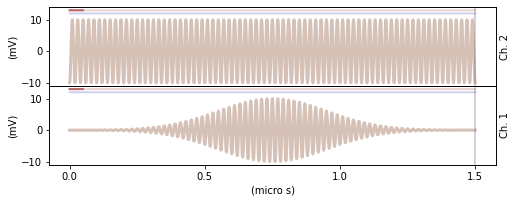

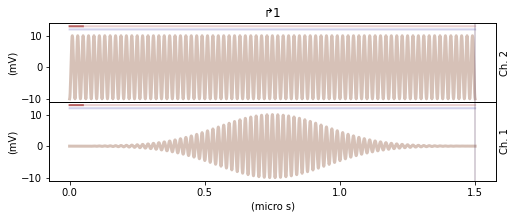

In [158]:
#all in one box,
# sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
# bp1 = bb.BluePrint()
# bp1.setSR(1e9)
# bp1.insertSegment(1, 'waituntil', (300e-9,))

# # bp1.insertSegment(1, sine, (20e6, 5e-3, 0, 0), name='mysine', dur=201e-9)
# bp1.insertSegment(3, sine, (50e6, 50e-3, 0, 0), name='mysine', dur=201e-9)
# bp1.insertSegment(4, 'waituntil', (800e-9,))
# bp1.showPrint()
# plotter(bp1)
#make a basic sinusoidal element
sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
bpsine = bb.BluePrint()
bpsine.setSR(1e9)
bpsine.insertSegment(1, sine, (50e6, 10e-3, 0, 3*np.pi/2), name='sine', dur=1501e-9)
bpsine.marker1 = [(0,50e-9)]

#make a gaussian pulse blueprint
gaussbp = bb.BluePrint()
gaussbp.setSR(1e9)
gaussbp.insertSegment(1, gaussian_pulse, (50e6,3*np.pi/2,10e-3,200e-9,0,0), name = 'gaussian', dur = 1501e-9)
gaussbp.marker1 = [(0,50e-9)]

sineEl = bb.Element()
sineEl.addBluePrint(2,bpsine)
sineEl.addBluePrint(1,gaussbp)
plotter(sineEl)




###############################################
#put elements into sequence
sineSeq = bb.Sequence()
sineSeq.addElement(1, sineEl)
sineSeq.setSR(1e9)

#now we have to prep it for the AWG
sineSeq.setChannelAmplitude(1, 50e-3)  # Call signature: channel, amplitude (peak-to-peak)
sineSeq.setChannelOffset(1, 0)
sineSeq.setChannelAmplitude(2, 50e-3) 
sineSeq.setChannelOffset(2, 0)

#set the sequencing
# Here we repeat each element twice and then proceed to the next, wrapping over at the end
sineSeq.setSequencingTriggerWait(1, 0)
sineSeq.setSequencingNumberOfRepetitions(1, 1)
sineSeq.setSequencingEventJumpTarget(1, 0)
sineSeq.setSequencingGoto(1, 1)

sineSeq.checkConsistency()
plotter(sineSeq)

In [159]:
#upload to AWG
package = sineSeq.outputForAWGFile()
chan1_awg_input = package[0]
package.channels
awg.make_send_and_load_awg_file(*package[:])

In [144]:
sineEl/40

TypeError: unsupported operand type(s) for /: 'Element' and 'int'